## AWS Lambda Network Bandwidth Benchmark

This notebook presents results of AWS Lambda network performance benchmark.

## Methodology

Benchmarks were performed as follows:

1. Create an EC2 Instance (c5.xlarge) that runs an iperf3 instance
2. Create a Lambda function that runs iperf3 client
3. Execute Lambda function that executes iperf3 against a server running in EC2 with following options:
   * `--time 60` - Continue benchmark for 60 seconds.
4. Save report to Amazon S3 as JSON, and delete EC2 and Lambda resources.

The benchmark was performed with a select combination of Lambda function sizes (Memory):
* 128 MB
* 256 MB
* 512 MB
* 1024 MB
* 1792 MB (gives exactly 1 vCPU)
* 2048 MB
* 3008 MB

The results shown is this notebook were obtained on 2020-06-16 from eu-north-1 and eu-west-1 regions.


## Preparation

In [1]:
import gzip
import json
import math
import os
import os.path

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_data(path_filter):
    """Load reports that match given path filter"""
    report_files = sorted([os.path.join(root, file) for root, dirs, files in os.walk('data/') for file in files])    
    rows = []
    for file in report_files:
        if path_filter not in file:
            # Skip file since its path did not match the filter
            continue
            
        # Gunzip & json decode report
        with gzip.open(file) as fp:
            report = json.load(fp)

        memory = report['client']['memory']
        for interval in report['intervals']:
            rows.append({
                'region': report['aws_region'],
                'memory': int(memory),
                'time': interval['sum']['start'],
                'time_minutes': interval['sum']['start'] / 60,
                'rate': interval['sum']['bits_per_second'],
                'rate_gb': interval['sum']['bits_per_second'] / 1000 / 1000 / 1000,
                'bytes': interval['sum']['bytes'],
                'bytes_gb': interval['sum']['bytes'] / 1024 / 1024 / 1024
            })
    print('Got %s datapoints with filter %s' % (len(rows), path_filter))

    return pd.DataFrame(rows)

def graph_throughput(df):
    """Draw graphs of throughput over time."""
    for key, grp in df.groupby(['memory']):
        label = '%s MB' % (key)
        plot = grp.plot(kind='line', x='time', y='rate_gb', label=label, ylim=(0.0, 4.0))
        plt.ylabel('Throughput (Gbps)')
        plt.xlabel('Time (seconds)')

def compute_summary_table(df):
    """Compute summary for bandwidth of different cpu / memory combos"""
    summary_data = []
    for memory, grp in df.groupby(['memory']):
        quantiles = grp['rate_gb'].quantile([0.1, 0.999])
        grp = grp.set_index('time')
        grp['rate_diff'] = grp['rate_gb'].diff().fillna(0).round(2)
        rate_drop_time = grp[grp['rate_gb'] >= quantiles[0.999]].index.max()

        summary_data.append({
            'Memory (MB)': memory,
            'Baseline (Gbps)': round(quantiles[0.1], 3),
            'Burst (Gbps)': round(quantiles[0.999], 3),
            'Burst Duration (seconds)': '-' if rate_drop_time > 1100 else round(rate_drop_time)
        })

    return pd.DataFrame(summary_data)


In [3]:
!aws --profile admin s3 --quiet sync s3://en1-network-benchmark-infra-reports/reports/ data/eu-north-1/
!aws --profile admin s3 --quiet sync s3://ew1-network-benchmark-infra-reports/reports/ data/eu-west-1/

In [4]:
df_ew1 = load_data('eu-west-1/date=2020-06-16/run=lambda_60s_out')
df_en1 = load_data('eu-north-1/date=2020-06-16/run=lambda_60s_out')


Got 420 datapoints with filter eu-west-1/date=2020-06-16/run=lambda_60s_out
Got 420 datapoints with filter eu-north-1/date=2020-06-16/run=lambda_60s_out


In [5]:
# eu-north-1
df_en1.head()

,region,memory,time,time_minutes,rate,rate_gb,bytes,bytes_gb
0,eu-north-1,1024,0.000000,0.000000,1.823802e+09,1.823802,228000728,0.212342
1,eu-north-1,1024,1.000112,0.016669,5.871726e+08,0.587173,73400320,0.068359
2,eu-north-1,1024,2.000163,0.033336,6.606366e+08,0.660637,82575360,0.076904
3,eu-north-1,1024,3.000112,0.050002,5.976786e+08,0.597679,74711040,0.069580
4,eu-north-1,1024,4.000128,0.066669,6.396173e+08,0.639617,79953920,0.074463


## Results - eu-north-1

Summary of network performance on different kinds of Lambda functions in eu-north-1 region.

In [6]:
en1_summary = compute_summary_table(df_en1)
en1_summary

,Memory (MB),Baseline (Gbps),Burst (Gbps),Burst Duration (seconds)
0,128,0.594,1.720,0.0
1,256,0.586,1.751,0.0
2,512,0.598,1.763,0.0
3,1024,0.586,1.756,0.0
4,1792,0.587,1.744,0.0
5,2048,0.597,1.755,0.0
6,3008,0.587,1.738,0.0


Graphs of network throughput over time (minutes since benchmark began).

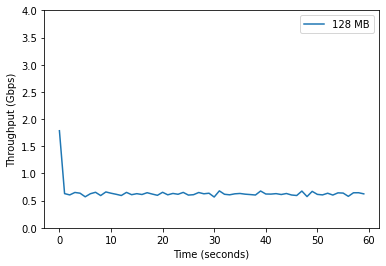

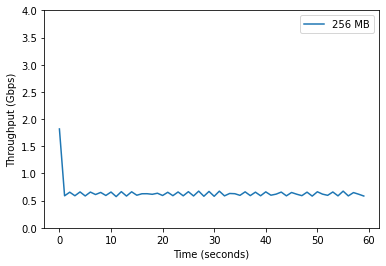

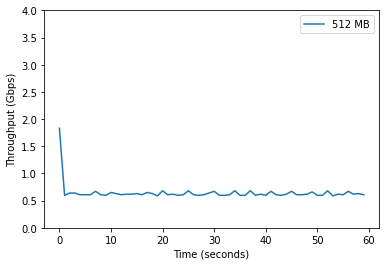

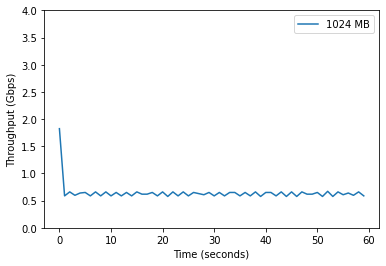

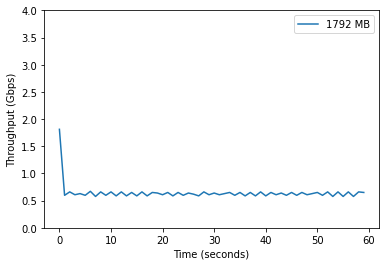

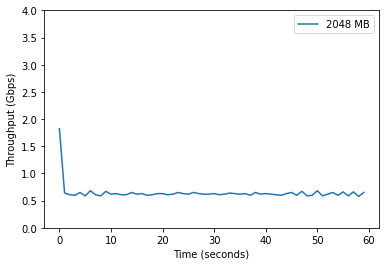

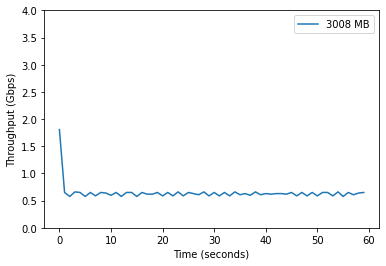

In [7]:
graph_throughput(df_en1)

### Observations

We can make the following observations from above results:

* Lambda functions have a stable 600 Mbps network throughput with a small burst to 1.7 Gbps in the beginning


## Results - eu-west-1

Summary of network performance on different kinds of Lambda functions in eu-west-1 region.

In [8]:
en1_summary = compute_summary_table(df_ew1)
en1_summary

,Memory (MB),Baseline (Gbps),Burst (Gbps),Burst Duration (seconds)
0,128,0.590,1.640,0.0
1,256,0.593,1.703,0.0
2,512,0.598,1.769,0.0
3,1024,0.598,1.751,0.0
4,1792,0.608,1.750,0.0
5,2048,0.608,1.747,0.0
6,3008,0.607,1.730,0.0


Graphs of network throughput over time (minutes since benchmark began).

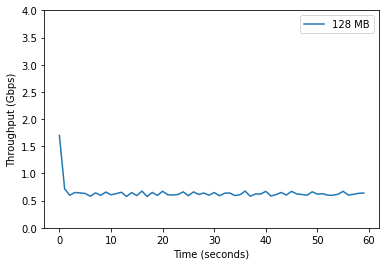

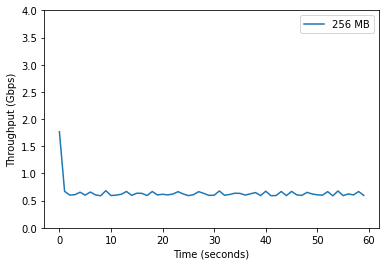

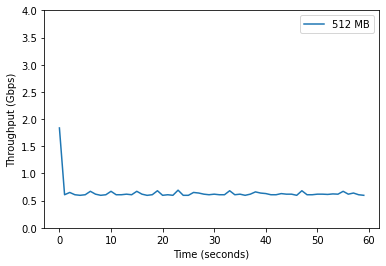

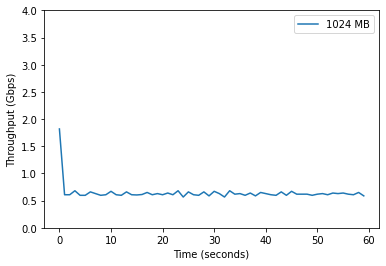

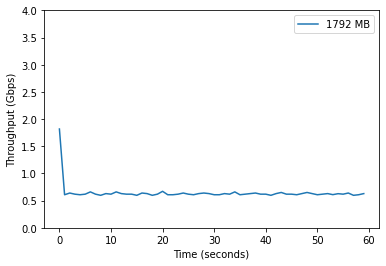

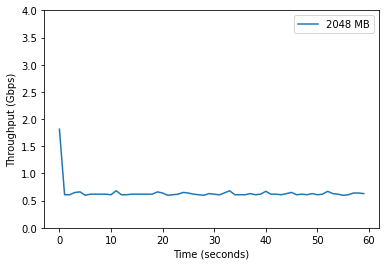

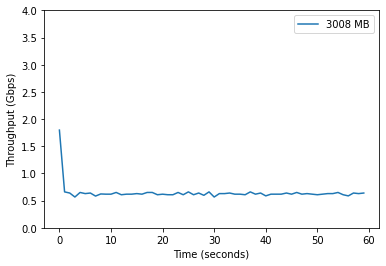

In [9]:
graph_throughput(df_ew1)

### Observations

We can make the following observations from above results:

* Lambda functions have a stable 600 Mbps network throughput with a small burst to 1.7 Gbps in the beginning
* No differences between regions
